<center>
    <h1>Human Value Detection - Pooling Model</h1>
    <h2>Bonini Roberto, Maidana Facundo Nicolas</h2>
    <h3>roberto.bonini@studio.unibo.it, facundo.maidana@studio.unibo.it</h3>
</center>

## Requirements

In [3]:
!nvidia-smi

Tue May 23 20:41:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install --quiet wandb transformers peft pytorch-lightning 

In [5]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [6]:
%cd /content
!rm -r human-value-detection
!git clone  https://github.com/maidacundo/human-value-detection.git
%cd human-value-detection

/content
Cloning into 'human-value-detection'...
remote: Enumerating objects: 750, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 750 (delta 50), reused 63 (delta 27), pack-reused 662
Receiving objects: 100% (750/750), 1.92 MiB | 10.80 MiB/s, done.
Resolving deltas: 100% (449/449), done.
/content/human-value-detection


### Imports

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/human-value-detection')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl

from torchmetrics import Accuracy

from utils import seed
from utils.data import get_processed_df, HumanValuesDataset, HumanValuesDataModule
from models.baseline import TransformerClassifier
from models.pooling_model import TransformerClassifierPooling

from utils.thresholding import ThresholdModel, SurrogateHeaviside, train_thresholding_model, get_f1_optimized_thresholding, print_classification_report_thresholding

from IPython.core.display import clear_output

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from functools import partial

In [9]:
RANDOM_STATE = 42
seed.fix_random(RANDOM_STATE)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [10]:
import torch 
device = "cpu"
if torch.cuda.is_available:
  print('Running on GPU')
  device = torch.device("cuda:0")  
else:
  print('Running on CPU, please set GPU.')

Running on GPU


## Data

In [11]:
DATA_ROOT_FOLDER = 'data'

arguments_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-training.tsv', delimiter='\t')
labels_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-training.tsv', delimiter='\t')

arguments_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-validation.tsv', delimiter='\t')
labels_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-validation.tsv', delimiter='\t')

arguments_test = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-test.tsv', delimiter='\t')

In [12]:
df_train_original = arguments_train.merge(labels_train)
df_test_original = arguments_val.merge(labels_val)
df_train_augmented = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-training-augmented.csv')

In [13]:
labels_columns = labels_train.drop('Argument ID', axis=1).columns

# Models

## all-mpnet-base-v2

In addition to the baseline approach, we propose a
new model architecture that incorporates additional
information from the full output sequence. Specifi-
cally, our model utilizes the final hidden states of
all input tokens, rather than just the first token as
Figure 3: Architecture of the Proposed Transformer
Classifier with Pooling
in the standard approach. This allows our model
to capture more nuanced relationships between the
input sequence and the target label.
Our proposed model was inspired by (Leheˇcka
et al., 2020) architecture, where authors adapt on
top of the BERT transformer a time-distributed
fully connected dense layer to improve the model’s
ability to handle long-range dependencies and per-
form mean and max pooling. We decided to avoid
the usage of LSTM and rely on MPNet, which
combines the strengths of masked and permuted
language modeling for handling the long-range de-
pendencies between words. Our proposed solu-
tion, uses the whole output of transformers (and
not just the [CLS] one), by pooling it using both
max-pooling and mean-pooling. Max-pooling ex-
tracts the strongest class-related features from the
sequence while average-pooling evenly attends to
all tokens in the sequence. All padding tokens were
ignored when computing the pooled values.
The pooled features are then summed together
and normalized, and fed into a final classification
layer as in the baseline. Our proposed model does
not add any trainable parameter.

In [17]:
model_name = 'sentence-transformers/all-mpnet-base-v2'
num_labels = len(labels_columns)

N_EPOCHS = 10
batch_size = 16

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [18]:
train_df = get_processed_df(df_train_original, labels_columns, tokenizer.sep_token)
test_df = get_processed_df(df_test_original, labels_columns, tokenizer.sep_token)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'train shape: {train_df.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (4314, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [19]:
train_df_aug = get_processed_df(df_train_augmented, labels_columns, tokenizer.sep_token)
train_df_aug = pd.concat([train_df, train_df_aug], ignore_index=True)

print(f'train shape aug: {train_df_aug.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape aug: (5916, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [20]:
steps_per_epoch=len(train_df_aug) // batch_size
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = steps_per_epoch * 2
print('scheduled steps', (warmup_steps, total_training_steps))

scheduled steps (738, 3690)


In [21]:
data_module = HumanValuesDataModule(train_df, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module.setup()

data_module_aug = HumanValuesDataModule(train_df_aug, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module_aug.setup()

### LoRA Config

In [22]:
import wandb
wandb.login(key='e9ec24521d2c9a845865b5e4d6be07386c8843aa')

wandb: Currently logged in as: nlp-project-unibo (human-value-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from peft import LoraConfig
import numpy as np

targets = [["q", "v"], ["q", "v", "k", "v"]]

for rank in [8, 16]:
    for lr_transformer in [1e-4, 4e-4]:
        for weight_decay in [1e-4, 1e-3]:
            for target in targets:
                lora_config = LoraConfig(
                                r=rank,
                                lora_alpha=8,
                                lora_dropout=0.1,
                                bias="all",
                                target_modules=target,
                            )
                lora_model = TransformerClassifierPooling(model_name, 
                                                            num_labels, 
                                                            classifier_dropout=0.1, 
                                                            optimizer=torch.optim.AdamW, 
                                                            lr_transformer=lr_transformer, 
                                                            lr_classifier=2e-3,
                                                            weight_decay=weight_decay,
                                                            n_training_steps=total_training_steps, 
                                                            n_warmup_steps=warmup_steps,
                                                            use_lora=True,
                                                            lora_config=lora_config
                                                            ) 

                checkpoint_callback = ModelCheckpoint(
                  dirpath="checkpoints",
                  filename="best-checkpoint",
                  save_top_k=1,
                  verbose=True,
                  monitor="val_loss",
                  mode="min"
                )
                early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1, min_delta=.002)
                lr_monitor = LearningRateMonitor(logging_interval='step')
                tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")

                try:
                    wandb.finish()
                except:
                    pass

                run_name=f'LoRA_mpnet_r{rank}_{"".join(target)}_{lr_transformer}_{weight_decay}'
                wandb_logger = WandbLogger(project="human-value-final", name=run_name)

                trainer = pl.Trainer(
                  logger=[tensorboard_logger, wandb_logger],
                  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
                  max_epochs=N_EPOCHS,
                  accelerator='gpu'
                )
                # log gradients, parameter histogram and model topology
                wandb_logger.watch(lora_model, log="all")
                trainer.fit(lora_model, data_module_aug)
                
                lora_model.eval()
                lora_model.freeze()

                predictions_train = trainer.predict(lora_model, data_module_aug.threshold_train_dataloader())
                predictions_test = trainer.predict(lora_model, data_module_aug.test_dataloader())

                pred_labels_train = np.array([pred.cpu().numpy() for preds in predictions_train for pred in preds])
                true_labels_train = np.array([i for i in train_df['labels']])
                pred_labels_test = np.array([pred.cpu().numpy() for preds in predictions_test for pred in preds])
                true_labels_test = np.array([i for i in test_df['labels']])

                MANUAL_THRESHOLD = .5
                f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, pred_labels_train, labels_columns)
                print(f'optimized_thresholds: \n{f1_score_optimized_thresholds}')

                print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                del lora_model
                del trainer
                torch.cuda.empty_cache()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | MPNetModel        | 109 M 
1 | lora_model | PeftModel         | 109 M 
2 | dropout    | Dropout           | 0     
3 | classifier | Linear            | 15.4 K
4 | loss_fn    | BCEWithLogitsLoss | 0     
5 | metrics    | ModuleDict        | 0     
-------------------------------------------------
413 K     Trainable params
109 M     Non-trainable params
109 M     T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 370: 'val_loss' reached 0.41615 (best 0.41615), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 740: 'val_loss' reached 0.37131 (best 0.37131), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


### Training

In [53]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' '/content/drive/MyDrive/human-value-detection/models/pooling-mpnet-aug.ckpt'

In [54]:
plt.plot([i.cpu().item() for i in pooling_model_aug.losses])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'plt' is not defined

### Predictions

In [35]:
trained_model = lora_pooling_model

In [ ]:
trained_model = TransformerClassifierPooling.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/pooling-mpnet-aug.ckpt",
  **{'model_name':model_name, 
     'num_labels':num_labels, 
     'classifier_dropout':.1, 
     'optimizer':torch.optim.AdamW,
     'lr_transformer':5e-05, 
     'lr_classifier':1e-5,
     'weight_decay':1e-4,
     'n_training_steps':total_training_steps, 
     'n_warmup_steps':warmup_steps,
     },
)

In [36]:
trained_model.eval()
trained_model.freeze()

In [37]:
predictions_train = trainer.predict(trained_model, data_module.threshold_train_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [40]:
predictions_test = trainer.predict(trained_model, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [41]:
pred_labels_test = np.array([pred.cpu().numpy() for preds in predictions_test for pred in preds])
true_labels_test = np.array([i for i in test_df['labels']])

#### Threshold Optimization

https://arxiv.org/pdf/2103.00833.pdf

https://github.com/topel/sglthresh/blob/master/sgl_emotions.ipynb

In [42]:
MANUAL_THRESHOLD = .5

In [43]:
f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, pred_labels_train, labels_columns)
print(f'optimized_thresholds: \n{f1_score_optimized_thresholds}')

optimized_thresholds: 
[0.4, 0.4, 0.4, 0.5, 0.35, 0.5, 0.65, 0.3, 0.4, 0.55, 0.6, 0.45, 0.4, 0.5, 0.3, 0.25, 0.4, 0.6, 0.5, 0.3]


--------------------
learned_thresholds: 
[0.29655418 0.2883069  0.43584654 0.4942383  0.247547   0.41204542
 0.46357697 0.30915907 0.22833599 0.26744035 0.34102234 0.25896993
 0.3274744  0.3994595  0.23200493 0.25858602 0.23125963 0.36807668
 0.40559474 0.21493834]


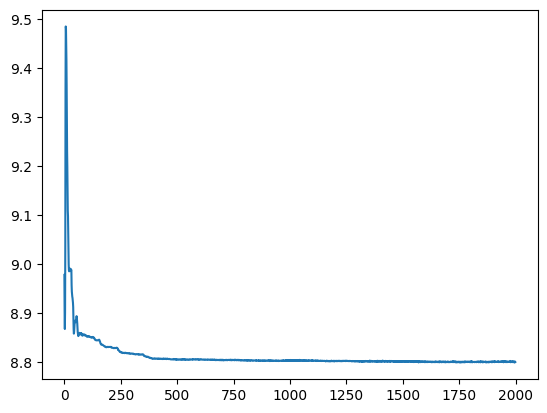

In [44]:
threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds: \n{learned_thresholds}')

#### Train

In [45]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=0.25)

                            precision    recall  f1-score   support

   Self-direction: thought       0.56      0.85      0.67       804
    Self-direction: action       0.54      0.83      0.65      1134
               Stimulation       0.26      0.59      0.36       196
                  Hedonism       0.28      0.83      0.42       137
               Achievement       0.59      0.84      0.69      1212
          Power: dominance       0.32      0.73      0.44       482
          Power: resources       0.43      0.94      0.59       496
                      Face       0.32      0.59      0.42       304
        Security: personal       0.64      0.87      0.74      1594
        Security: societal       0.59      0.90      0.72      1383
                 Tradition       0.47      0.85      0.60       454
         Conformity: rules       0.47      0.78      0.58       928
 Conformity: interpersonal       0.41      0.70      0.52       172
                  Humility       0.34      0.71

In [46]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.66      0.77      0.71       804
    Self-direction: action       0.67      0.71      0.69      1134
               Stimulation       0.40      0.46      0.43       196
                  Hedonism       0.47      0.64      0.54       137
               Achievement       0.68      0.78      0.72      1212
          Power: dominance       0.52      0.50      0.51       482
          Power: resources       0.62      0.75      0.68       496
                      Face       0.36      0.50      0.42       304
        Security: personal       0.74      0.78      0.76      1594
        Security: societal       0.78      0.72      0.75      1383
                 Tradition       0.70      0.65      0.67       454
         Conformity: rules       0.63      0.59      0.61       928
 Conformity: interpersonal       0.53      0.56      0.55       172
                  Humility       0.56      0.49

In [47]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.59      0.82      0.69       804
    Self-direction: action       0.57      0.80      0.66      1134
               Stimulation       0.42      0.41      0.42       196
                  Hedonism       0.48      0.65      0.55       137
               Achievement       0.59      0.84      0.69      1212
          Power: dominance       0.44      0.56      0.49       482
          Power: resources       0.52      0.85      0.65       496
                      Face       0.36      0.48      0.41       304
        Security: personal       0.63      0.89      0.73      1594
        Security: societal       0.61      0.89      0.72      1383
                 Tradition       0.54      0.80      0.65       454
         Conformity: rules       0.48      0.77      0.59       928
 Conformity: interpersonal       0.47      0.62      0.54       172
                  Humility       0.46      0.56

#### Test


In [48]:
print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=0.25)

                            precision    recall  f1-score   support

   Self-direction: thought       0.40      0.73      0.52       251
    Self-direction: action       0.45      0.77      0.57       496
               Stimulation       0.33      0.36      0.35       138
                  Hedonism       0.32      0.58      0.41       103
               Achievement       0.57      0.78      0.66       575
          Power: dominance       0.22      0.49      0.31       164
          Power: resources       0.34      0.86      0.49       132
                      Face       0.24      0.29      0.26       130
        Security: personal       0.62      0.90      0.74       759
        Security: societal       0.44      0.81      0.57       488
                 Tradition       0.37      0.58      0.45       172
         Conformity: rules       0.45      0.75      0.56       455
 Conformity: interpersonal       0.27      0.22      0.24        60
                  Humility       0.16      0.30

In [49]:
print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.50      0.57      0.54       251
    Self-direction: action       0.59      0.59      0.59       496
               Stimulation       0.45      0.23      0.31       138
                  Hedonism       0.52      0.42      0.46       103
               Achievement       0.64      0.69      0.66       575
          Power: dominance       0.40      0.24      0.30       164
          Power: resources       0.45      0.56      0.50       132
                      Face       0.26      0.20      0.23       130
        Security: personal       0.71      0.84      0.77       759
        Security: societal       0.63      0.49      0.55       488
                 Tradition       0.51      0.40      0.45       172
         Conformity: rules       0.57      0.52      0.54       455
 Conformity: interpersonal       0.50      0.10      0.17        60
                  Humility       0.27      0.11

In [50]:
pooling_aug_report = print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.42      0.68      0.52       251
    Self-direction: action       0.50      0.72      0.59       496
               Stimulation       0.48      0.22      0.31       138
                  Hedonism       0.52      0.42      0.46       103
               Achievement       0.57      0.78      0.66       575
          Power: dominance       0.34      0.30      0.32       164
          Power: resources       0.40      0.70      0.51       132
                      Face       0.26      0.18      0.22       130
        Security: personal       0.60      0.91      0.72       759
        Security: societal       0.45      0.79      0.58       488
                 Tradition       0.41      0.52      0.46       172
         Conformity: rules       0.46      0.74      0.57       455
 Conformity: interpersonal       0.30      0.12      0.17        60
                  Humility       0.23      0.17

# Error Analysis


In [ ]:
pooling_reports = [pooling_aug_report]

In [ ]:
import pickle
with open('/content/human-value-detection/baseling_bert_base_reports.pkl', 'rb') as f:
    baseling_bert_base_reports = pickle.load(f)

with open('/content/human-value-detection/baseling_mpnet_base_reports.pkl', 'rb') as f:
    baseling_mpnet_base_reports = pickle.load(f)

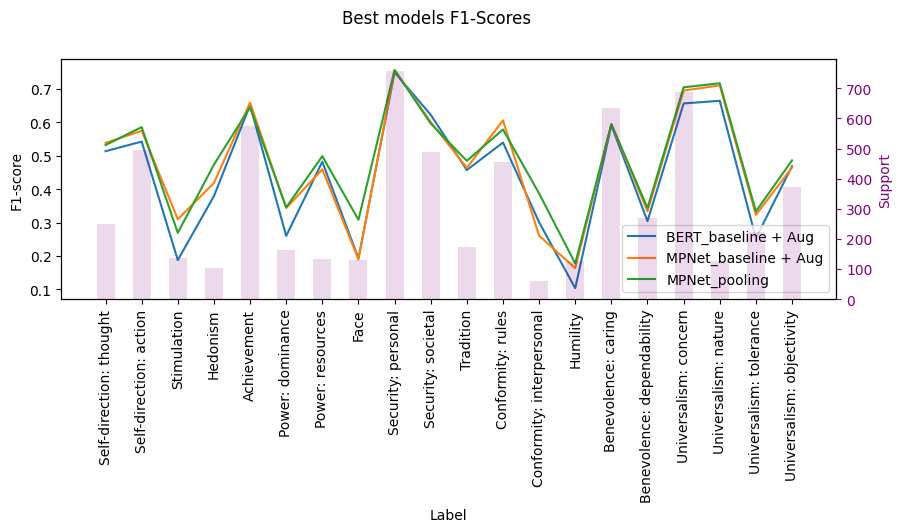

In [ ]:
from plotting.data_analysis import plot_classification_reports

reports = [baseling_bert_base_reports[1], baseling_mpnet_base_reports[1], pooling_reports[0]]
reports_names = ['BERT_baseline + Aug', 'MPNet_baseline + Aug', 'MPNet_pooling + Aug']

plot_classification_reports(reports, reports_names, 'Best models F1-Scores')